In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [128]:
# Directory containing CSV files
directory = 'data/'

# List to store DataFrames
dfs = []

# Loop through each CSV file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        # Read the CSV file into a DataFrame and append it to the list
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        dfs.append(df)

# Concatenate all DataFrames in the list into a single DataFrame
combined_df = pd.concat(dfs, ignore_index=True)


In [129]:
# Group the DataFrame by the 'beta' column
grouped_df = combined_df.groupby('beta')

# Create an empty dictionary to store the arrays
beta_arrays = {}

# Iterate over the groups
for beta, group in grouped_df:
    # Store the group as an array in the dictionary
    beta_arrays[beta] = group.to_numpy()


In [130]:
def temp_flipper(betas):
    """
    Converts a list of beta values to corresponding temperature values.
    
    Parameters:
    betas (list): A list of beta values.
    
    Returns:
    list: A list of temperature values corresponding to the given beta values.
    """
    T_0 = []
    for i in range(len(betas)):
        temp_T_0 = 1/betas[i]
        T_0.append(temp_T_0)    
        
    return T_0

In [131]:
def heat_capacity(betas, energy):
    """
    Calculate the heat capacity for a given list of betas and energy values.

    Args:
        betas (list): A list of beta values.
        energy (list): A list of energy values.

    Returns:
        list: A list of heat capacity values.

    """
    c = []
    gridSize = 40
    N = gridSize**2
    for i in range(len(betas)):
        temp_c = betas[i] * N * energy[i]
        c.append(temp_c)
        
    return c
    

In [132]:
def plotter(depVar, col, sweepRange, plot=False, task4=False):
    """Function plot dependant variable against number of sweeps
    dependantVar: give string that dependant variable will be called
    col: column index of dependant variable starting from 0
    sweepRange: range over which sweeps are plotted, always plots from zero -> may want to change
    """
    
    if plot:
        plt.figure(figsize=(8, 6))  # Width: 8 inches, Height: 6 inches
    
    # task 2
    eqns = []
    betas = []
    eqns_err = []
    
    if task4:
        variance = []
        variance_err = []
    
    for beta, array in beta_arrays.items(): 
        
        # find number of seeds iterated over
        max_seed = 0
        for i in range(len(array)):
            if array[i][5] > max_seed:
                max_seed = int(array[i][5]) 

        # I don't know why I have to put this in
        max_seed += 2

        # magnetisation array for task 1
        # columns are: sweeps, magnetisation, error
        independentVar = np.zeros(max_seed)
        dependantVar = np.zeros(max_seed)

        # errors
        value_squares = np.zeros(max_seed)
        value_errors = []

        # iterates over every beta value
        for i in range(len(array)):
            
            j = int(array[i][0])
            # appends sweeps
            independentVar[j] = array[i][0]
            # appends dependantVar
            dependantVar[j] += array[i][col] / 50
            # appends dependantVar squared for error stuff
            value_squares[j] += array[i][col]**2 / 50

        prefactor = 1 / ( np.sqrt( max_seed) -1 ) 
        for k in range(len(value_squares)):
            value_errors.append( prefactor * np.sqrt(value_squares[k] - dependantVar[k]**2) )
                        
        if plot:
            plt.errorbar(independentVar, dependantVar, yerr=value_errors, fmt='o', capsize=3, label=beta)
            
            plt.legend()
            # Set tick parameters inwards
            plt.tick_params(axis='both', direction='in')
            plt.xlabel('Sweeps')
            plt.xlim(0, sweepRange)

            plt.ylabel(depVar)
        
        # task 2: finding equilibrium averages
        # slice arrays
        independentVar = independentVar[10:sweepRange+1]
        dependantVar = dependantVar[10:sweepRange+1]
        value_errors = value_errors[10:sweepRange+1]
        # sqaures for task 4:
        value_squares = value_squares[10:sweepRange+1]
        
        
        # mean of dependant variables (magnetisation or energy) for given beta value
        eqDepVar = np.mean(dependantVar)
        # error in mean of dependant variable
        eqDepVar_err = np.std(dependantVar) / np.sqrt(len(dependantVar))
        eqns.append(eqDepVar)
        betas.append(beta)
        eqns_err.append(eqDepVar_err)
        
    
        
        # finds mean of squares if we want to carry out task 4
        if task4:
            # calulates variance in dependant variable
            depVar_variance = np.mean(value_squares) - eqDepVar**2
            depVar_variance_err = np.sqrt( (2* depVar_variance**4)/(max_seed-2) )
            variance.append(depVar_variance)
            variance_err.append(depVar_variance_err)

        
        
    if plot:
        plt.savefig(f"figures/task1_{depVar}.png")
        plt.show()
        
    if task4:
        return betas, variance, variance_err
    else:    
        return betas, eqns, eqns_err 

In [133]:
# task 3:

# function calculates magnetisation using (16)
def theory_mag(beta):
    
    if beta < 0.45:
        print(f"Theory is not valid for this beta = {beta}")
        return

    m = ( 1 - 1/(np.sinh(2.27 * beta * np.log(1 + np.sqrt(2) ) )**4 ) )**(1/8)
    
    return m

x_data = np.linspace(0.45, 1, 100)
m_data = []

for i in range(len(x_data)):
    m_data.append(theory_mag(x_data[i]))
    


/var/folders/j0/4jbn0h55721bgq7ld4mp7qjw0000gn/T/ipykernel_9439/2658823520.py:53: RuntimeWarning: invalid value encountered in sqrt
  value_errors.append( prefactor * np.sqrt(value_squares[k] - dependantVar[k]**2) )


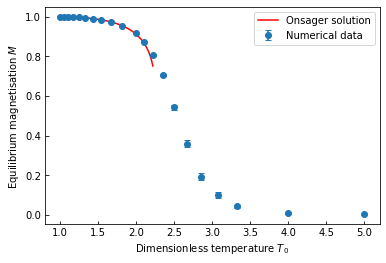

In [134]:
# task 2: calculate the equilibrium averages

# magnetisation:
betas = plotter("Magnetisation", 2, 50)[0]
eqM = plotter("Magnetisation", 2, 50)[1]
eqM_err = plotter("Magnetisation", 2, 50)[2]

T_0 = temp_flipper(betas)

T_02 = temp_flipper(x_data)

plt.errorbar(T_0, eqM, yerr=eqM_err, fmt='o', capsize=3, label="Numerical data")

plt.plot(T_02, m_data, linestyle="-", label="Onsager solution", color="r")

plt.legend()
            
# Set tick parameters inwards
plt.tick_params(axis='both', direction='in')
plt.xlabel('Dimensionless temperature $T_0$')

# # comment out to set x lims
# plt.xlim(1, 2.5)
# plt.ylim(0.4,1.1)

plt.ylabel("Equilibrium magnetisation $M$")
plt.savefig("figures/task2_magnetisation.png")

/var/folders/j0/4jbn0h55721bgq7ld4mp7qjw0000gn/T/ipykernel_9439/2658823520.py:53: RuntimeWarning: invalid value encountered in sqrt
  value_errors.append( prefactor * np.sqrt(value_squares[k] - dependantVar[k]**2) )


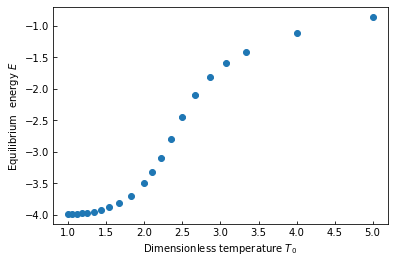

In [135]:
# task 2 equilibrium averages: energy
betas, eqE, eqE_err = plotter("Dimensionless energy $E$", 3, 50)

T_0 = temp_flipper(betas)

plt.errorbar(T_0, eqE, yerr=eqE_err, fmt='o', capsize=3)
            
# Set tick parameters inwards
plt.tick_params(axis='both', direction='in')
plt.xlabel('Dimensionless temperature $T_0$')
# plt.xlim(0, sweepRange)

plt.ylabel("Equilibrium  energy $E$")

plt.savefig("figures/task2_energy.png")

Text(0, 0.5, '$f_{(m)}$')

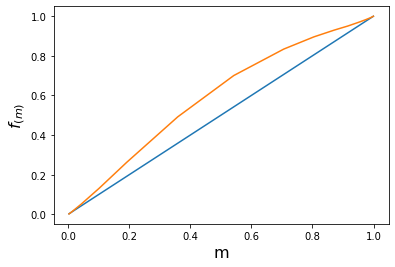

In [136]:
plt.plot(eqM, eqM, marker='', linestyle="-", label="$f_{(m)}$ = m")

bruh = []
for i in range(len(betas)):
    bruh.append(np.tanh(4 * eqM[i] * betas[i]))

plt.plot(eqM, bruh, marker='', linestyle="-")
plt.xlabel("m", fontsize=16)
plt.ylabel("$f_{(m)}$", fontsize=16)


/var/folders/j0/4jbn0h55721bgq7ld4mp7qjw0000gn/T/ipykernel_9439/2658823520.py:53: RuntimeWarning: invalid value encountered in sqrt
  value_errors.append( prefactor * np.sqrt(value_squares[k] - dependantVar[k]**2) )


Text(0, 0.5, 'Heat Capacity $c$')

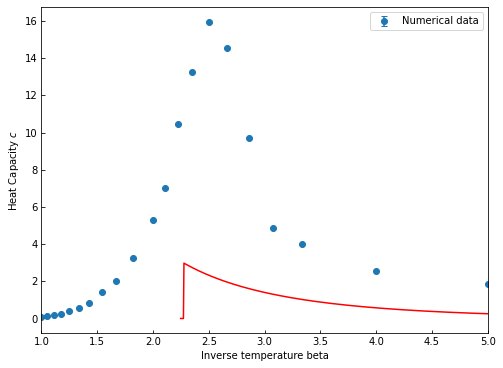

In [144]:
# task 4, calculate specific heat capacity c 

k_b = 1.381e-23
    
betas, energy, energy_err = plotter("heat capacity", 3, 50, task4=True)

# heat capacity
c = heat_capacity(betas, energy)
# heat capacity error
# dc = heat_capacity(betas, energy_err)
c_err = []

for i in range(len(c)):
    temp_c_err = 2 * energy_err[i] * energy[i]
    c_err.append(temp_c_err)
T_0 = temp_flipper(betas)


# read in meanfield data

meanfield_data = pd.read_csv("meanfield_isingdata_CSV.csv")

c_meanfield = meanfield_data['c']
T_Tc_meanfield = meanfield_data['T/T_C']

meanfield_data['T_0'] = 2.27* 1/meanfield_data['T/T_C']

T_meanfield = meanfield_data['T_0']


# plotting
plt.figure(figsize=(8, 6))  # Width: 8 inches, Height: 6 inches

plt.errorbar(T_0, c, yerr=c_err, fmt='o', capsize=3, label="Numerical data")

plt.plot(T_meanfield, c_meanfield, linestyle="-", color = 'r')
plt.xlim(1,5)

# plt.plot(T_O_meanfield, c)

# plt.plot(betas, c, marker='o', linestyle="")            
plt.legend()
# Set tick parameters inwards
plt.tick_params(axis='both', direction='in')
plt.xlabel('Inverse temperature beta')

plt.ylabel("Heat Capacity $c$")
